In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=50

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/dataset",shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size= BATCH_SIZE)

Found 501 files belonging to 5 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Grass Shoots', 'Healthy', 'Mites', 'Ring Spot', 'YLD']

(16, 256, 256, 3)
[3 1 0 2 0 0 1 1 2 1 2 0 3 3 1 4]


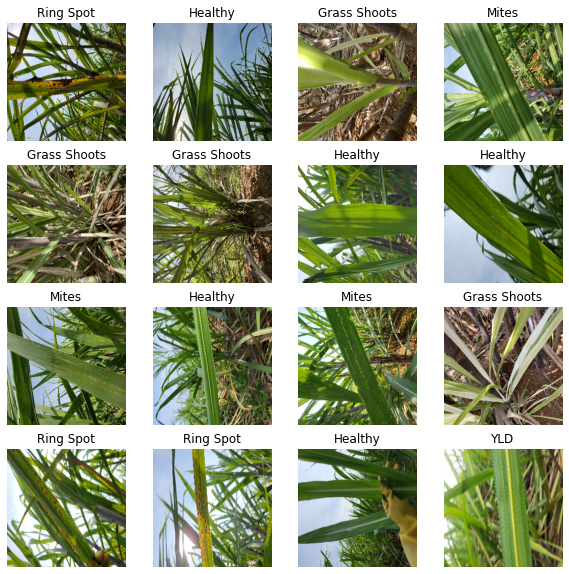

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+test_split+val_split)==1
  ds_size = len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=6)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

25

In [ ]:
len(val_ds)

3

In [ ]:
len(test_ds)

4

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[5.97173691e-01 7.05713868e-01 8.39702070e-01]
  [7.60784328e-01 8.23529422e-01 9.13725495e-01]
  [7.64705896e-01 8.27450991e-01 9.17647064e-01]
  ...
  [1.10106461e-01 1.80694699e-01 2.41268383e-04]
  [1.05399817e-01 1.74800858e-01 0.00000000e+00]
  [1.20607384e-01 2.01593131e-01 1.72334563e-04]]

 [[7.43627429e-01 8.13181698e-01 8.97032022e-01]
  [7.56759346e-01 8.19504440e-01 9.09700513e-01]
  [7.64215708e-01 8.26960802e-01 9.17156875e-01]
  ...
  [1.02742031e-01 1.70622706e-01 0.00000000e+00]
  [1.41222432e-01 2.12791055e-01 1.76930148e-02]
  [9.89928022e-02 1.77424178e-01 0.00000000e+00]]

 [[7.50490189e-01 8.13235283e-01 9.03431356e-01]
  [7.53431380e-01 8.16176474e-01 9.06372547e-01]
  [7.64705896e-01 8.27450991e-01 9.17647064e-01]
  ...
  [6.39552698e-02 1.29457727e-01 0.00000000e+00]
  [6.98337927e-02 1.38197005e-01 3.17861530e-04]
  [1.09195009e-01 1.78829655e-01 0.00000000e+00]]

 ...

 [[1.70415908e-01 1.46369487e-01 1.92516856e-02]
  [1.69952512e-01 1.42501533e-01 2.9266

In [ ]:
resizing_and_rescaling=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [ ]:
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),layers.experimental.preprocessing.RandomRotation(0.2)])

In [ ]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5
model=models.Sequential([
    resizing_and_rescaling,
    data_augmentation,
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50


25/25 [==============================] - 274s 2s/step - loss: 1.6182 - accuracy: 0.1825 - val_loss: 1.5807 - val_accuracy: 0.1875
Epoch 2/50
25/25 [==============================] - 2s 65ms/step - loss: 1.4120 - accuracy: 0.3522 - val_loss: 0.8571 - val_accuracy: 0.6250
Epoch 3/50
25/25 [==============================] - 2s 63ms/step - loss: 1.1237 - accuracy: 0.4884 - val_loss: 0.8780 - val_accuracy: 0.6458
Epoch 4/50
25/25 [==============================] - 2s 63ms/step - loss: 1.0167 - accuracy: 0.5681 - val_loss: 0.7956 - val_accuracy: 0.6667
Epoch 5/50
25/25 [==============================] - 2s 63ms/step - loss: 0.8597 - accuracy: 0.6452 - val_loss: 0.4888 - val_accuracy: 0.7917
Epoch 6/50
25/25 [==============================] - 2s 80ms/step - loss: 0.8263 - accuracy: 0.6761 - val_loss: 0.5773 - val_accuracy: 0.7708
Epoch 7/50
25/25 [==============================] - 2s 71ms/step - loss: 0.7265 - accuracy: 0.7172 - val_loss: 0.3007 - val_accuracy: 0.8750
Epoch 8/50
25/25 [======

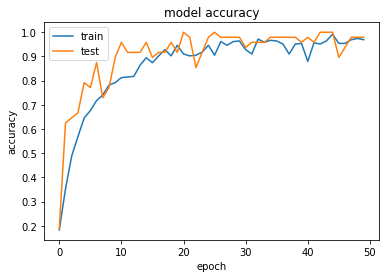

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

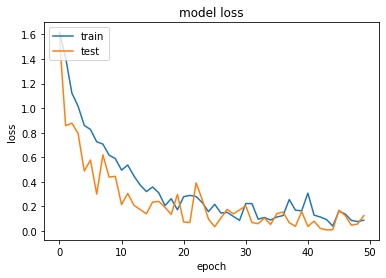

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
scores=model.evaluate(test_ds)

4/4 [==============================] - 38s 23ms/step - loss: 0.1026 - accuracy: 0.9531


In [ ]:
def predict (model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


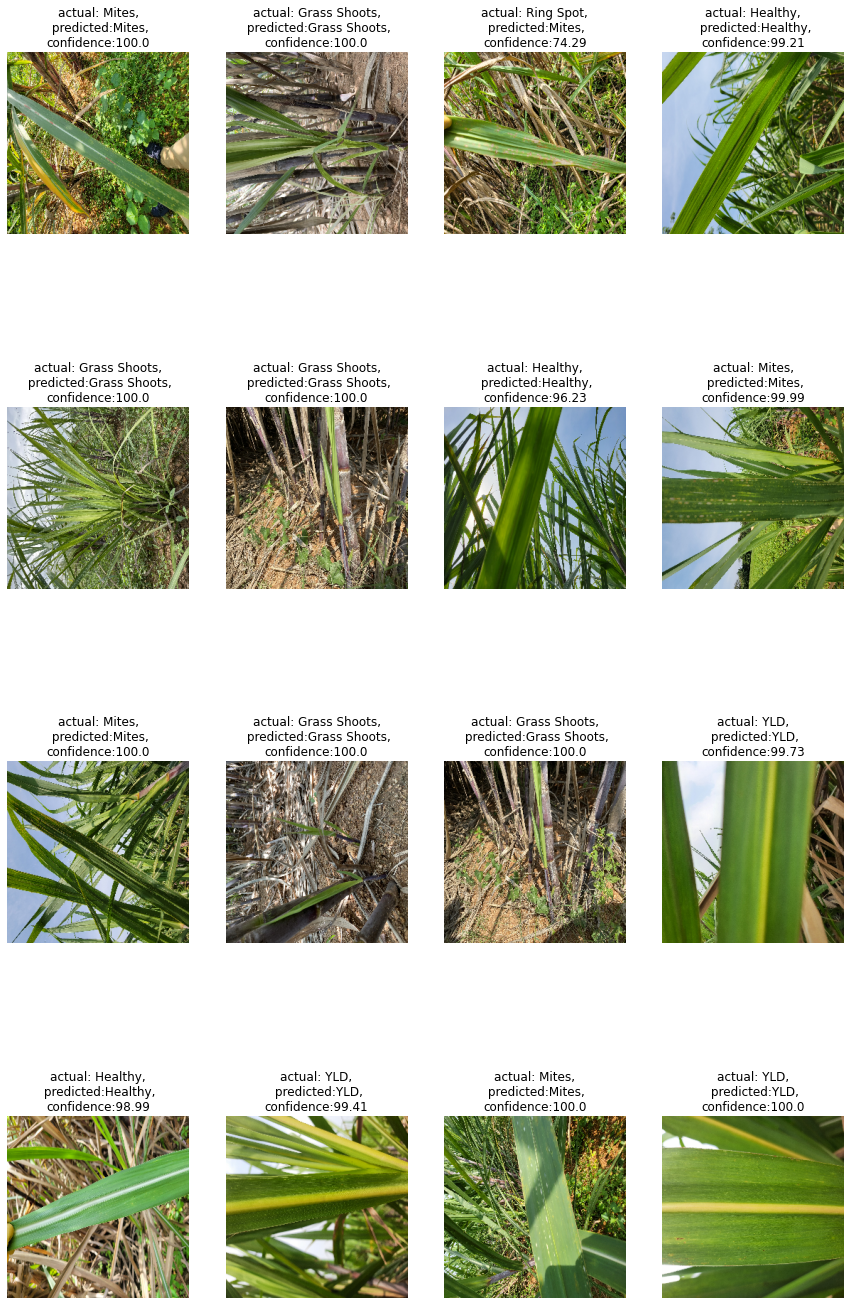

In [ ]:
import numpy as np
plt.figure(figsize=(15,25))
for images,labels in test_ds.take(1):
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"actual: {actual_class},\n predicted:{predicted_class},\nconfidence:{confidence}")
    plt.axis("off")

In [ ]:
model.save("/content/drive/MyDrive/Model1.h5")